## 1. Bài toán đặt ra

### Tên bài toán
 Dự đoán số điểm tổng kết của khách hàng đánh giá cho hãng hàng không British Airways
 
### Giới thiệu chung 
- Trong học máy, **học có giám sát** là một nhóm các thuật toán phổ biến trong lĩnh vực này và một trong những vấn đề quan trọng của học có giám sát là hồi quy(regression). Hồi quy là các bài toán liên quan đến việc dự đoán đầu ra có giá trị liên tục (predicting continous valued output).
- Và trong bài toán mà nhóm đề ra thì từ những cột thuộc tính đầu vào như loại ghế, loại khách, đánh giá về chỗ ngồi, chất lượng phục vụ của nhân viên, thức ăn và đồ uống,.... Nhóm tiến hành dự đoán cột Overall_rating là số điểm tổng kết của khách hàng đánh giá bằng thuật toán hồi quy tuyến tính (linear regression).

## 2. Thêm thư viện

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression

## 3. Chuẩn bị dữ liệu

### Đọc dữ liệu đã qua tiền xử lí

In [2]:
data = pd.read_csv('../data/cleaned_data.csv')

### Loại những thuộc tính không có ý nghĩa cho việc mô hình hóa
- Như đã quan sát ở phần khám phá dữ liệu: Cột `Date_published`, `Name`, `Review_header`, `Review_body`, `Route`, `Date_flown` chứa các giá trị quá riêng biệt, không có ý nghĩa cho việc trực quan hay phân tích do đó các cột này sẽ không được lựa chọn làm thuộc tính đầu vào.
- Cột `Recommended` hầu như dựa vào số điểm của cột `Overall_rating` để đề xuất nên cũng không có giá trị cho bài toán
- Các cột của bộ dữ liệu được giữ lại bao gồm: `Verified_review`, `Type_of_traveller`, `Seat_type`, `Seat_comfort`, `Cabin_staff_service`, `Food_and_beverages`, `Inflight_entertainments`, `Ground_service	`, `Value_for_money`, `Overall_rating`

In [3]:
data = data.drop(columns=['Date_published', 'Name', 'Review_header', 'Review_body', 'Route', 'Date_flown', 'Recommended'])
data.head()

,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money,Overall_rating
0,Trip Verified,Family Leisure,Business Class,4,5,5,3,5,5,10
1,Trip Verified,Solo Leisure,Economy Class,1,1,3,3,1,1,1
2,Not Verified,Family Leisure,Premium Economy,3,3,3,3,1,1,1
3,Trip Verified,Solo Leisure,Business Class,3,4,1,3,3,5,6
4,Not Verified,Couple Leisure,Business Class,4,5,1,3,5,5,6


### Chuyển đổi các cột không phải dạng số về dạng số 
Chuyển các cột `Verified_review`, `Type_of_traveller`, `Seat_type` , `Recommended` về dạng số để làm đầu vào cho mô hình học máy, tuy nhiên các cột có dạng số này vẫn mang ý nghĩa phân loại.

In [5]:
enc = OrdinalEncoder()
data[['Verified_review', 'Type_of_traveller', 'Seat_type']]=enc.fit_transform(np.array(data[['Verified_review', 'Type_of_traveller',
                                                            'Seat_type']]))
data.head()

,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money,Overall_rating
0,1.0,2.0,0.0,4,5,5,3,5,5,10
1,1.0,3.0,1.0,1,1,3,3,1,1,1
2,0.0,2.0,3.0,3,3,3,3,1,1,1
3,1.0,3.0,0.0,3,4,1,3,3,5,6
4,0.0,1.0,0.0,4,5,1,3,5,5,6


### Tính Correlations giữa các thuộc tính
- Correlation là mức độ liên quan của hai biến để có mối quan hệ tuyến tính với nhau hay không. Correlation cao nhất có giá trị là 1 (hai biến hoàn toàn có quan hệ tuyến tính) và thấp nhất dần nếu hai biến càng không có quan hệ tuyến tính.
- Nhóm sẽ tạo một dataframe tên là 'correlations' chứa các correlations của từng cột trong bộ dữ liệu để dễ dàng nhận xét mức độ tương quan giữa các biến.

In [6]:
correlations = pd.DataFrame(data, columns=['Overall_rating', 'Verified_review', 'Type_of_traveller', 'Seat_type', 'Seat_comfort', 'Cabin_staff_service',
                 'Food_and_beverages', 'Inflight_entertainments', 'Ground_service', 'Value_for_money']).corr()
correlations

,Overall_rating,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money
Overall_rating,1.000000,0.094155,0.144578,-0.012915,0.703127,0.696266,0.669566,0.451289,0.710631,0.874127
Verified_review,0.094155,1.000000,-0.052838,0.033466,0.030431,0.027108,-0.035613,-0.047321,0.084948,0.081808
Type_of_traveller,0.144578,-0.052838,1.000000,0.112357,0.120836,0.097547,0.119837,0.087806,0.102616,0.149276
Seat_type,-0.012915,0.033466,0.112357,1.000000,0.064667,-0.043022,-0.046287,0.001386,-0.003508,-0.005700
Seat_comfort,0.703127,0.030431,0.120836,0.064667,1.000000,0.591298,0.568927,0.465288,0.526800,0.663503
Cabin_staff_service,0.696266,0.027108,0.097547,-0.043022,0.591298,1.000000,0.646208,0.391144,0.513002,0.640205
Food_and_beverages,0.669566,-0.035613,0.119837,-0.046287,0.568927,0.646208,1.000000,0.495826,0.442412,0.628528
Inflight_entertainments,0.451289,-0.047321,0.087806,0.001386,0.465288,0.391144,0.495826,1.000000,0.319470,0.417707
Ground_service,0.710631,0.084948,0.102616,-0.003508,0.526800,0.513002,0.442412,0.319470,1.000000,0.655822
Value_for_money,0.874127,0.081808,0.149276,-0.005700,0.663503,0.640205,0.628528,0.417707,0.655822,1.000000


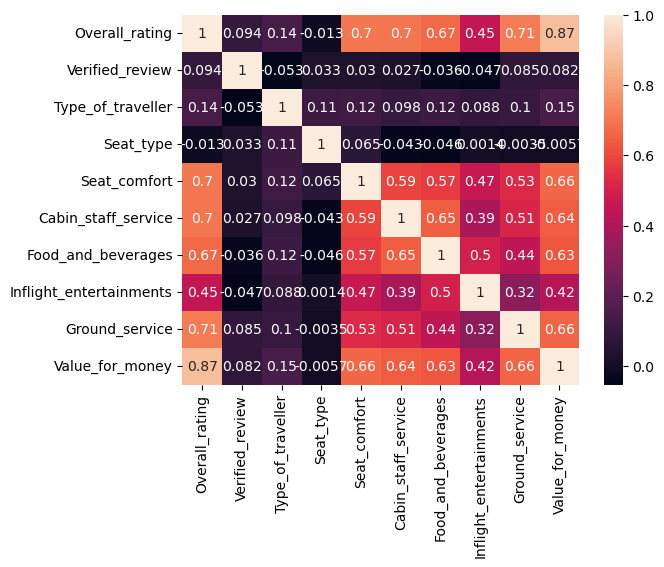

In [7]:
#vẽ heatmap thể hiện các correlation
sns.heatmap(correlations,annot=True);